[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Pepper-Capsicum_annuum-Healthy-PRX-RGB-NA-20200812-20210225103251**, datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_pytorch_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to train an autoencoder with PyTorch for removing noise from input images.

Autoencoders are a type of unsupervised neural network (i.e., no class labels or labeled data). As shown in the figure below, typically, autoencoders have two components/subnetworks:

1. **Encoder**: Accepts the input data (images) and compresses it into a smaller representation.
2. **Decoder**: The decoder is responsible for accepting the latent-space representation and then reconstructing the original input.

<img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" width='350'>

Autoencoders are basically a technique for data compression, similar to the way an audio file is compressed using MP3, or an image file is compressed using JPEG. The aim of the autoencoder is to find a model (weights) which will require the minimum information to encode the image such that it can be recreated on the decoder side.

If we use too few neurons in the bottleneck layer (last layer), the capacity to recreate the image will be limited and  created images could be blurry or distorted. On the other hand, if the encoder uses too many neurons, then there is no compression. 

Moreover, autoencoders are typically used for:

1. **Dimensionality reduction**: If all the activation functions used within the autoencoder are linear, the latent variables present at the bottleneck, correspond to the principal components from PCA.
2. **Denoising** (This notebook)
3. **Anomaly/outlier detection** (e.g.: detecting mislabeled data points in a dataset or detecting when an input data point falls well outside our typical data distribution).

In **agriculture**, researchers have used autoencoders for anomaly/novelty detection (Alexandridis et al., 2017) and denoising (Wen et al., 2015).

Check more highly inspirational tutorials on Autoencoders: [References](#References)

#### Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

import os
import os
from tqdm import tqdm
from glob import glob

from torchsummary import summary
import cv2


print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

/home/beast/anaconda3/envs/eden_pytorch_transfer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


#### Utility functions

In [2]:
def train_epoch_denoising(
    autoencoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3
):
    """
    It trains the denoising autoencoder for 1 epoch.
    """
    train_loss = []
    # Set Training mode
    autoencoder.train()

    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor=noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)

        decoded_data = autoencoder(image_noisy)
        loss = loss_fn(decoded_data, image_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


def val_epoch_denoising(
    autoencoder, device, dataloader, loss_fn, noise_factor=0.3
):
    """
    It validates the denoising autoencoder for 1 epoch.
    """
    # Set evaluation mode
    autoencoder.eval()
    with torch.no_grad():  # No need to track the gradients
        outputs = []
        src_images = []
        for image_batch, _ in dataloader:
            # Adding noise
            image_noisy = add_noise(image_batch, noise_factor)
            image_noisy = image_noisy.to(device)
            # Cleaning the noisy images
            decoded_data = autoencoder(image_noisy)
            # Append the network output and the original image to the results.
            outputs.append(decoded_data.cpu())
            src_images.append(image_batch.cpu())
        # Create a single tensor with all the values.
        outputs = torch.cat(outputs)
        src_images = torch.cat(src_images)
        # Evaluate the loss of the whole validation set.
        val_loss = loss_fn(outputs, src_images)
    return val_loss.data.detach().cpu().numpy()


def plot_src_images(image_batch, noise_factor):
    """
    It plots a sample of the original images with and without noise.
    """

    plt.figure(figsize=(10, 6))
    for i in range(NUM_COLUMNS_PLOT):
        plt.subplot(2, NUM_COLUMNS_PLOT, i + 1)
        img = image_batch[i].unsqueeze(0)
        if i == 0:
            plt.title("Original Images")
        plt.imshow(img.permute(0, 2, 3, 1).cpu().squeeze().numpy())
        plt.axis("off")
        image_noisy = add_noise(img, noise_factor)
        plt.subplot(2, NUM_COLUMNS_PLOT, NUM_COLUMNS_PLOT + i + 1)
        if i == 0:
            plt.title("Noisy Images")
        plt.imshow(image_noisy.permute(0, 2, 3, 1).cpu().squeeze().numpy())
        plt.axis("off")
    plt.show()


def plot_reconstructed_images(autoencoder, image_batch, noise_factor=0.3):
    """
    It plots the reconstructed images from image_batch after each iteration.
    """
    plt.figure(figsize=(10, 3))

    for i in range(NUM_COLUMNS_PLOT):
        plt.subplot(1, NUM_COLUMNS_PLOT, i + 1)
        img = image_batch[i].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)
        autoencoder.eval()
        with torch.no_grad():
            rec_img = autoencoder(image_noisy)
        plt.subplot(1, NUM_COLUMNS_PLOT, i + 1)
        plt.imshow(rec_img.cpu().permute(0, 2, 3, 1).squeeze().numpy())
        plt.axis("off")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstructed images")
    plt.show()


def read_data(path_list, im_size=(128,128)):
    
    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    print(tag2idx)
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file) 
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                X.append(im/255)
                y.append(tag2idx[label])# Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Exception")
                print(e)
    
    X = np.array(X) #Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y #np.array(y)

def get_dataloaders():
    """
    It returns the DataLoaders necessary for training and validating.
    """
    data_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((INPUT_SIZE, INPUT_SIZE))]
    )

    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(TARGET_DATA_DIR, data_transforms)
    dataset_length = len(image_dataset)
    train_dataset, val_dataset = random_split(
        image_dataset, [int(dataset_length * 0.8) + 1, int(dataset_length * 0.2)]
    )
    # Create training and validation dataloaders
    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
    )
    val_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
    )

    return train_dataloader, val_dataloader


def get_dataloaders(x, y):
    """
    It returns the DataLoaders necessary for training and validating.
    """
    data_transforms = transforms.Compose(
        [transforms.ToTensor()]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    train_dataset = TensorDataset(torch.permute(torch.Tensor(x_train), (0, 3, 1, 2)), 
                                  torch.Tensor(y_train)) # create your datset
    #train_dataset.transform = data_transforms
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE) # create your dataloader
    valid_dataset = TensorDataset(torch.permute(torch.Tensor(x_test), (0, 3, 1, 2)), torch.Tensor(y_test)) # create your datset
    #valid_dataset.transform = data_transforms
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE) # create your dataloader

    return train_loader, valid_loader


def add_noise(inputs, noise_factor=0.3):
    """
    Given a batch of input images, it returns them with Gaussian noise added.
    """
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0.0, 1.0)
    return noisy

#### Experimental Constants

In [137]:
# For reproducibility purposes
RANDOM_STATE = 2022
torch.manual_seed(RANDOM_STATE)
# Dataset constant
SRC_DATA_DIR = "Pepper-Capsicum_annuum-Healthy-PRX-RGB-NA-20200812-20210225103251"
TARGET_DATA_DIR = "pytorch_autoencoder_eden_data"
INPUT_SIZE = 256
# Training constants
BATCH_SIZE = 32
NUM_EPOCHS = 300
LEARNING_RATE = 0.001
# Experiment constant
NOISE_FACTOR = 0.3
# Visualization constant
NUM_COLUMNS_PLOT = 4

In [4]:
x, y = read_data([TARGET_DATA_DIR + "/" + SRC_DATA_DIR], (INPUT_SIZE, INPUT_SIZE))

{'Pepper-Capsicum_annuum-Healthy-PRX-RGB-NA-20200812-20210225103251': 0}


100%|██████████| 354/354 [00:50<00:00,  6.99it/s]


#### Defining Encoder Architecture

In [138]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),  # 256*256*3 -> 128*128*64
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # 128*128*64 -> 64*64*32
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 64*64*32 -> 32*32*16
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 64*64*32 -> 32*32*16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 64*64*32 -> 32*32*16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 64*64*32 -> 32*32*16
            #nn.BatchNorm2d(256),
            #nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_linear1 = nn.Linear(128*8*8, 8192)
        #self.encoder_linear2 = nn.Linear(2048, 1024)

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        #x = self.encoder_linear1(x)
        #x = self.encoder_linear2(x)
        return x

#### Defining Decoder Architecture

In [139]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        #self.decoder_lin1 = nn.Linear(1024, 2048)
        self.decoder_lin2 = nn.Linear(8192, 128*8*8)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 8, 8))
        self.decoder_conv = nn.Sequential(
            #nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            #nn.BatchNorm2d(128),
            #nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),
            #nn.ReLU(True),
            #nn.ConvTranspose2d(128, 3, 3, padding=1),
        )

    def forward(self, x):
        #x = self.decoder_lin1(x)
        #x = self.decoder_lin2(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

#### Defining Autoencoder Architecture

In [140]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.decoder(self.encoder(x))
        return x

#### Creating Encoder, Decoder, Loss Function and Optimizer

In [141]:
loss_fn = nn.MSELoss()
autoencoder = Autoencoder()

optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, verbose=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

autoencoder.to(device)

print(f"Selected Device: {device}")

Selected Device: cuda


In [142]:
train_dataloader, val_dataloader = get_dataloaders(x, y)
image_batch = next(iter(train_dataloader))

<ipython-input-2-5f2714939f7f>:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, NUM_COLUMNS_PLOT, i + 1)


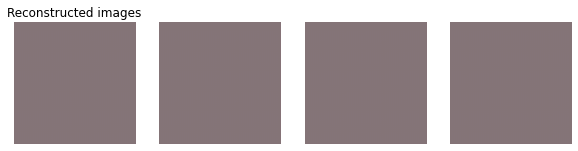

In [143]:
plot_reconstructed_images(
    autoencoder, image_batch[0], noise_factor=NOISE_FACTOR
)

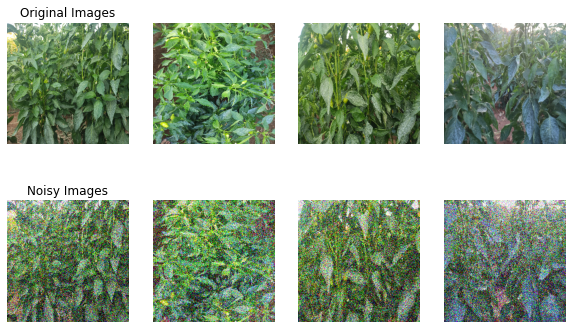

In [144]:
history_da = {"train_loss": [], "val_loss": []}
train_dataloader, val_dataloader = get_dataloaders(x, y)
image_batch = next(iter(val_dataloader))
plot_src_images(image_batch[0], NOISE_FACTOR)

#### Training / Validation Loop

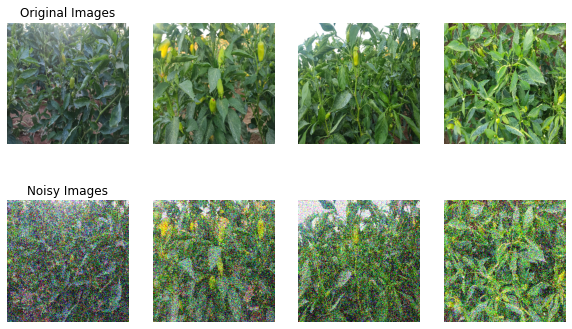


 EPOCH 1/300 	 train loss 0.06772 	 val loss 0.04936


<ipython-input-2-5f2714939f7f>:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, NUM_COLUMNS_PLOT, i + 1)


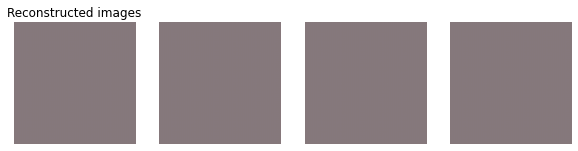


 EPOCH 2/300 	 train loss 0.05333 	 val loss 0.04955

 EPOCH 3/300 	 train loss 0.05023 	 val loss 0.04928

 EPOCH 4/300 	 train loss 0.04825 	 val loss 0.04864

 EPOCH 5/300 	 train loss 0.04666 	 val loss 0.0468

 EPOCH 6/300 	 train loss 0.04501 	 val loss 0.04462

 EPOCH 7/300 	 train loss 0.04277 	 val loss 0.04577

 EPOCH 8/300 	 train loss 0.04023 	 val loss 0.04761

 EPOCH 9/300 	 train loss 0.03792 	 val loss 0.04684

 EPOCH 10/300 	 train loss 0.03586 	 val loss 0.04357

 EPOCH 11/300 	 train loss 0.03397 	 val loss 0.03951

 EPOCH 12/300 	 train loss 0.03223 	 val loss 0.03707

 EPOCH 13/300 	 train loss 0.03051 	 val loss 0.03444

 EPOCH 14/300 	 train loss 0.02894 	 val loss 0.03393

 EPOCH 15/300 	 train loss 0.02754 	 val loss 0.03104

 EPOCH 16/300 	 train loss 0.02641 	 val loss 0.02812

 EPOCH 17/300 	 train loss 0.02547 	 val loss 0.02838

 EPOCH 18/300 	 train loss 0.02468 	 val loss 0.02674

 EPOCH 19/300 	 train loss 0.02403 	 val loss 0.02524

 EPOCH 20/300 	 tr

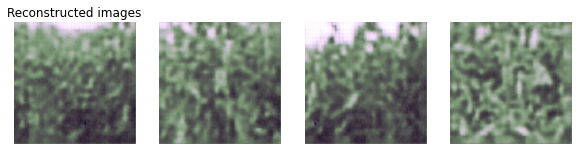


 EPOCH 22/300 	 train loss 0.02286 	 val loss 0.02401

 EPOCH 23/300 	 train loss 0.02244 	 val loss 0.02319

 EPOCH 24/300 	 train loss 0.02206 	 val loss 0.02138

 EPOCH 25/300 	 train loss 0.02176 	 val loss 0.02128

 EPOCH 26/300 	 train loss 0.02148 	 val loss 0.02108

 EPOCH 27/300 	 train loss 0.0212 	 val loss 0.02065

 EPOCH 28/300 	 train loss 0.02096 	 val loss 0.02065

 EPOCH 29/300 	 train loss 0.02074 	 val loss 0.01993

 EPOCH 30/300 	 train loss 0.02051 	 val loss 0.01938

 EPOCH 31/300 	 train loss 0.02028 	 val loss 0.01934

 EPOCH 32/300 	 train loss 0.02007 	 val loss 0.01922

 EPOCH 33/300 	 train loss 0.01986 	 val loss 0.01896

 EPOCH 34/300 	 train loss 0.01968 	 val loss 0.01848

 EPOCH 35/300 	 train loss 0.01949 	 val loss 0.01823

 EPOCH 36/300 	 train loss 0.01927 	 val loss 0.01829

 EPOCH 37/300 	 train loss 0.01905 	 val loss 0.01792

 EPOCH 38/300 	 train loss 0.01885 	 val loss 0.01794

 EPOCH 39/300 	 train loss 0.01869 	 val loss 0.01801

 EPOCH 40/

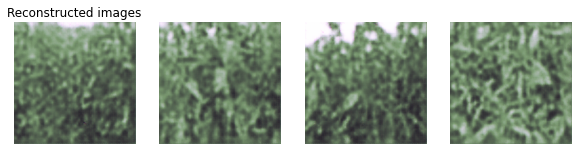


 EPOCH 42/300 	 train loss 0.0182 	 val loss 0.0177

 EPOCH 43/300 	 train loss 0.01805 	 val loss 0.01736

 EPOCH 44/300 	 train loss 0.01791 	 val loss 0.01691

 EPOCH 45/300 	 train loss 0.01784 	 val loss 0.0168

 EPOCH 46/300 	 train loss 0.01773 	 val loss 0.01717

 EPOCH 47/300 	 train loss 0.0176 	 val loss 0.01679

 EPOCH 48/300 	 train loss 0.01742 	 val loss 0.01664

 EPOCH 49/300 	 train loss 0.01729 	 val loss 0.01644

 EPOCH 50/300 	 train loss 0.01716 	 val loss 0.01608

 EPOCH 51/300 	 train loss 0.01705 	 val loss 0.01619

 EPOCH 52/300 	 train loss 0.01696 	 val loss 0.01603

 EPOCH 53/300 	 train loss 0.01689 	 val loss 0.01591

 EPOCH 54/300 	 train loss 0.01683 	 val loss 0.01567

 EPOCH 55/300 	 train loss 0.01686 	 val loss 0.01568

 EPOCH 56/300 	 train loss 0.01677 	 val loss 0.01612

 EPOCH 57/300 	 train loss 0.01662 	 val loss 0.01581

 EPOCH 58/300 	 train loss 0.01647 	 val loss 0.01544

 EPOCH 59/300 	 train loss 0.01634 	 val loss 0.01534

 EPOCH 60/300

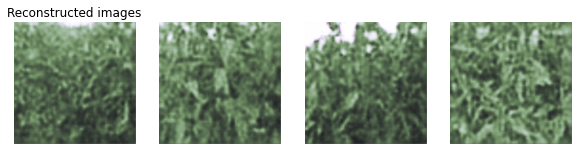


 EPOCH 62/300 	 train loss 0.01607 	 val loss 0.01511

 EPOCH 63/300 	 train loss 0.016 	 val loss 0.01513

 EPOCH 64/300 	 train loss 0.01592 	 val loss 0.01493

 EPOCH 65/300 	 train loss 0.01584 	 val loss 0.01484

 EPOCH 66/300 	 train loss 0.01577 	 val loss 0.01483

 EPOCH 67/300 	 train loss 0.0157 	 val loss 0.01486

 EPOCH 68/300 	 train loss 0.01567 	 val loss 0.01474

 EPOCH 69/300 	 train loss 0.01566 	 val loss 0.01458

 EPOCH 70/300 	 train loss 0.01572 	 val loss 0.01482

 EPOCH 71/300 	 train loss 0.01563 	 val loss 0.01471

 EPOCH 72/300 	 train loss 0.01552 	 val loss 0.01452

 EPOCH 73/300 	 train loss 0.01542 	 val loss 0.01441

 EPOCH 74/300 	 train loss 0.01536 	 val loss 0.01443

 EPOCH 75/300 	 train loss 0.01532 	 val loss 0.01447

 EPOCH 76/300 	 train loss 0.01528 	 val loss 0.01451

 EPOCH 77/300 	 train loss 0.01524 	 val loss 0.01433

 EPOCH 78/300 	 train loss 0.01519 	 val loss 0.01417

 EPOCH 79/300 	 train loss 0.01518 	 val loss 0.01424

 EPOCH 80/30

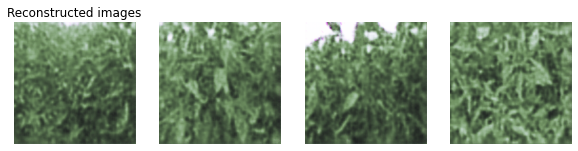


 EPOCH 82/300 	 train loss 0.01499 	 val loss 0.01406

 EPOCH 83/300 	 train loss 0.01495 	 val loss 0.01402

 EPOCH 84/300 	 train loss 0.01491 	 val loss 0.01402

 EPOCH 85/300 	 train loss 0.01487 	 val loss 0.01393

 EPOCH 86/300 	 train loss 0.01481 	 val loss 0.01393

 EPOCH 87/300 	 train loss 0.01471 	 val loss 0.01386

 EPOCH 88/300 	 train loss 0.01459 	 val loss 0.01378

 EPOCH 89/300 	 train loss 0.01451 	 val loss 0.01396

 EPOCH 90/300 	 train loss 0.01455 	 val loss 0.01386

 EPOCH 91/300 	 train loss 0.01444 	 val loss 0.01343

 EPOCH 92/300 	 train loss 0.01421 	 val loss 0.01328

 EPOCH 93/300 	 train loss 0.01407 	 val loss 0.01308

 EPOCH 94/300 	 train loss 0.01383 	 val loss 0.01335

 EPOCH 95/300 	 train loss 0.01361 	 val loss 0.01261

 EPOCH 96/300 	 train loss 0.01348 	 val loss 0.01268

 EPOCH 97/300 	 train loss 0.01343 	 val loss 0.01266

 EPOCH 98/300 	 train loss 0.01331 	 val loss 0.01282

 EPOCH 99/300 	 train loss 0.01324 	 val loss 0.01248

 EPOCH 10

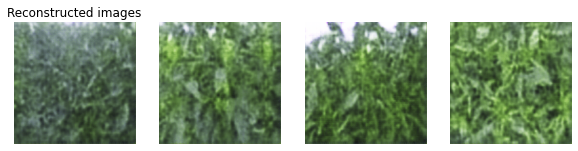


 EPOCH 102/300 	 train loss 0.01312 	 val loss 0.01255

 EPOCH 103/300 	 train loss 0.01301 	 val loss 0.0123

 EPOCH 104/300 	 train loss 0.01294 	 val loss 0.0121

 EPOCH 105/300 	 train loss 0.0129 	 val loss 0.01214

 EPOCH 106/300 	 train loss 0.01284 	 val loss 0.01213

 EPOCH 107/300 	 train loss 0.01279 	 val loss 0.0122

 EPOCH 108/300 	 train loss 0.01276 	 val loss 0.01214

 EPOCH 109/300 	 train loss 0.01275 	 val loss 0.01204

 EPOCH 110/300 	 train loss 0.01272 	 val loss 0.01195

 EPOCH 111/300 	 train loss 0.01273 	 val loss 0.01206

 EPOCH 112/300 	 train loss 0.01268 	 val loss 0.01208

 EPOCH 113/300 	 train loss 0.0126 	 val loss 0.01189

 EPOCH 114/300 	 train loss 0.01256 	 val loss 0.01181

 EPOCH 115/300 	 train loss 0.01257 	 val loss 0.01196

 EPOCH 116/300 	 train loss 0.01252 	 val loss 0.01192

 EPOCH 117/300 	 train loss 0.01247 	 val loss 0.01186

 EPOCH 118/300 	 train loss 0.01243 	 val loss 0.01168

 EPOCH 119/300 	 train loss 0.01242 	 val loss 0.011

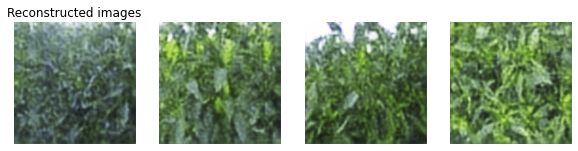


 EPOCH 122/300 	 train loss 0.01238 	 val loss 0.01171

 EPOCH 123/300 	 train loss 0.01236 	 val loss 0.01171

 EPOCH 124/300 	 train loss 0.01233 	 val loss 0.0117

 EPOCH 125/300 	 train loss 0.01236 	 val loss 0.01171

 EPOCH 126/300 	 train loss 0.01231 	 val loss 0.01163

 EPOCH 127/300 	 train loss 0.01226 	 val loss 0.01156

 EPOCH 128/300 	 train loss 0.01223 	 val loss 0.01157

 EPOCH 129/300 	 train loss 0.01219 	 val loss 0.0115

 EPOCH 130/300 	 train loss 0.01222 	 val loss 0.01164

 EPOCH 131/300 	 train loss 0.01225 	 val loss 0.0116

 EPOCH 132/300 	 train loss 0.01226 	 val loss 0.01156

 EPOCH 133/300 	 train loss 0.01217 	 val loss 0.01156

 EPOCH 134/300 	 train loss 0.01212 	 val loss 0.01145

 EPOCH 135/300 	 train loss 0.01211 	 val loss 0.01147

 EPOCH 136/300 	 train loss 0.0121 	 val loss 0.01144

 EPOCH 137/300 	 train loss 0.01207 	 val loss 0.0114

 EPOCH 138/300 	 train loss 0.01204 	 val loss 0.01151

 EPOCH 139/300 	 train loss 0.01203 	 val loss 0.011

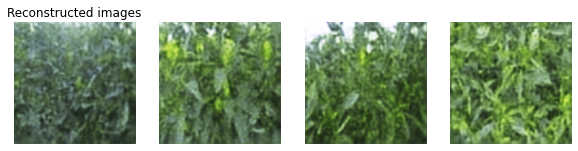


 EPOCH 142/300 	 train loss 0.01201 	 val loss 0.01138

 EPOCH 143/300 	 train loss 0.01203 	 val loss 0.01147

 EPOCH 144/300 	 train loss 0.01207 	 val loss 0.01136

 EPOCH 145/300 	 train loss 0.01203 	 val loss 0.01178

 EPOCH 146/300 	 train loss 0.01206 	 val loss 0.01149

 EPOCH 147/300 	 train loss 0.01203 	 val loss 0.01146

 EPOCH 148/300 	 train loss 0.01202 	 val loss 0.0113

 EPOCH 149/300 	 train loss 0.01196 	 val loss 0.01126

 EPOCH 150/300 	 train loss 0.01195 	 val loss 0.01133

 EPOCH 151/300 	 train loss 0.0119 	 val loss 0.01121

 EPOCH 152/300 	 train loss 0.01188 	 val loss 0.01126

 EPOCH 153/300 	 train loss 0.01187 	 val loss 0.01122

 EPOCH 154/300 	 train loss 0.01188 	 val loss 0.01126

 EPOCH 155/300 	 train loss 0.01188 	 val loss 0.01133

 EPOCH 156/300 	 train loss 0.01187 	 val loss 0.0112

 EPOCH 157/300 	 train loss 0.01182 	 val loss 0.0112

 EPOCH 158/300 	 train loss 0.0118 	 val loss 0.0112

 EPOCH 159/300 	 train loss 0.01183 	 val loss 0.0112

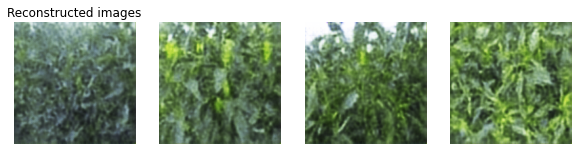


 EPOCH 162/300 	 train loss 0.0118 	 val loss 0.01133

 EPOCH 163/300 	 train loss 0.01178 	 val loss 0.01115

 EPOCH 164/300 	 train loss 0.01177 	 val loss 0.01141

 EPOCH 165/300 	 train loss 0.01183 	 val loss 0.01127

 EPOCH 166/300 	 train loss 0.01177 	 val loss 0.01117

 EPOCH 167/300 	 train loss 0.01174 	 val loss 0.01109

 EPOCH 168/300 	 train loss 0.01172 	 val loss 0.01103

 EPOCH 169/300 	 train loss 0.0117 	 val loss 0.01105

 EPOCH 170/300 	 train loss 0.01169 	 val loss 0.0111

 EPOCH 171/300 	 train loss 0.01168 	 val loss 0.01101

 EPOCH 172/300 	 train loss 0.01165 	 val loss 0.011

 EPOCH 173/300 	 train loss 0.01164 	 val loss 0.01115

 EPOCH 174/300 	 train loss 0.01165 	 val loss 0.01108

 EPOCH 175/300 	 train loss 0.01164 	 val loss 0.01101

 EPOCH 176/300 	 train loss 0.0117 	 val loss 0.0117

 EPOCH 177/300 	 train loss 0.01187 	 val loss 0.0118

 EPOCH 178/300 	 train loss 0.01186 	 val loss 0.01127

 EPOCH 179/300 	 train loss 0.01179 	 val loss 0.0113



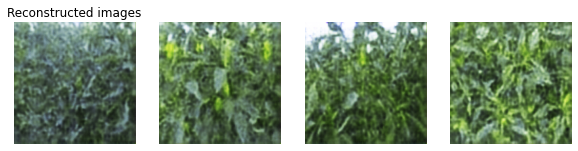


 EPOCH 182/300 	 train loss 0.01172 	 val loss 0.01116

 EPOCH 183/300 	 train loss 0.01159 	 val loss 0.01098

 EPOCH 184/300 	 train loss 0.01159 	 val loss 0.01102

 EPOCH 185/300 	 train loss 0.01156 	 val loss 0.01098

 EPOCH 186/300 	 train loss 0.01153 	 val loss 0.01093

 EPOCH 187/300 	 train loss 0.01153 	 val loss 0.01093

 EPOCH 188/300 	 train loss 0.01151 	 val loss 0.01093

 EPOCH 189/300 	 train loss 0.01149 	 val loss 0.01089

 EPOCH 190/300 	 train loss 0.01147 	 val loss 0.01084

 EPOCH 191/300 	 train loss 0.01147 	 val loss 0.01089

 EPOCH 192/300 	 train loss 0.01151 	 val loss 0.01093

 EPOCH 193/300 	 train loss 0.0115 	 val loss 0.01094

 EPOCH 194/300 	 train loss 0.01143 	 val loss 0.01091

 EPOCH 195/300 	 train loss 0.01138 	 val loss 0.01083

 EPOCH 196/300 	 train loss 0.01132 	 val loss 0.01081

 EPOCH 197/300 	 train loss 0.01131 	 val loss 0.01077

 EPOCH 198/300 	 train loss 0.0113 	 val loss 0.01076

 EPOCH 199/300 	 train loss 0.01129 	 val loss 0.

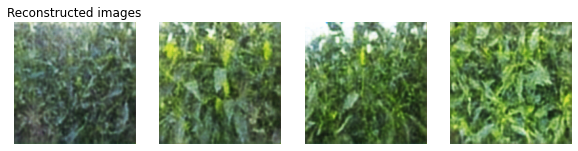


 EPOCH 202/300 	 train loss 0.01117 	 val loss 0.01065

 EPOCH 203/300 	 train loss 0.01116 	 val loss 0.01054

 EPOCH 204/300 	 train loss 0.01112 	 val loss 0.0106

 EPOCH 205/300 	 train loss 0.01114 	 val loss 0.01072

 EPOCH 206/300 	 train loss 0.01125 	 val loss 0.01173

 EPOCH 207/300 	 train loss 0.0113 	 val loss 0.01083

 EPOCH 208/300 	 train loss 0.01121 	 val loss 0.01076

 EPOCH 209/300 	 train loss 0.01112 	 val loss 0.01067

 EPOCH 210/300 	 train loss 0.01109 	 val loss 0.01059

 EPOCH 211/300 	 train loss 0.01107 	 val loss 0.0105

 EPOCH 212/300 	 train loss 0.01107 	 val loss 0.01056

 EPOCH 213/300 	 train loss 0.01108 	 val loss 0.01054

 EPOCH 214/300 	 train loss 0.01107 	 val loss 0.0105

 EPOCH 215/300 	 train loss 0.01108 	 val loss 0.01063

 EPOCH 216/300 	 train loss 0.01109 	 val loss 0.01063

 EPOCH 217/300 	 train loss 0.01112 	 val loss 0.01072

 EPOCH 218/300 	 train loss 0.0112 	 val loss 0.01112

 EPOCH 219/300 	 train loss 0.01114 	 val loss 0.010

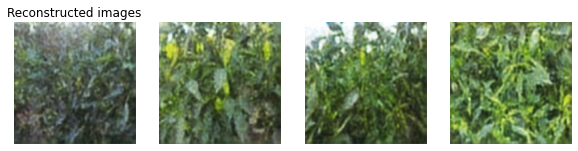


 EPOCH 222/300 	 train loss 0.01102 	 val loss 0.01056

 EPOCH 223/300 	 train loss 0.01103 	 val loss 0.01071

 EPOCH 224/300 	 train loss 0.01102 	 val loss 0.0107

 EPOCH 225/300 	 train loss 0.01101 	 val loss 0.01058

 EPOCH 226/300 	 train loss 0.01099 	 val loss 0.01045

 EPOCH 227/300 	 train loss 0.01094 	 val loss 0.01046

 EPOCH 228/300 	 train loss 0.01095 	 val loss 0.01061

 EPOCH 229/300 	 train loss 0.01094 	 val loss 0.0104

 EPOCH 230/300 	 train loss 0.01096 	 val loss 0.01047

 EPOCH 231/300 	 train loss 0.01094 	 val loss 0.0104

 EPOCH 232/300 	 train loss 0.01094 	 val loss 0.01055

 EPOCH 233/300 	 train loss 0.01097 	 val loss 0.01058

 EPOCH 234/300 	 train loss 0.01095 	 val loss 0.01059

 EPOCH 235/300 	 train loss 0.01095 	 val loss 0.01077

 EPOCH 236/300 	 train loss 0.01115 	 val loss 0.01181

 EPOCH 237/300 	 train loss 0.01111 	 val loss 0.01065

 EPOCH 238/300 	 train loss 0.01101 	 val loss 0.01058

 EPOCH 239/300 	 train loss 0.01099 	 val loss 0.0

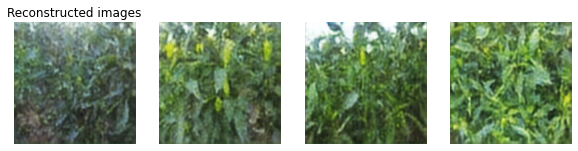


 EPOCH 242/300 	 train loss 0.01086 	 val loss 0.01058

 EPOCH 243/300 	 train loss 0.01084 	 val loss 0.01039

 EPOCH 244/300 	 train loss 0.01083 	 val loss 0.01035

 EPOCH 245/300 	 train loss 0.01081 	 val loss 0.01036

 EPOCH 246/300 	 train loss 0.01083 	 val loss 0.01036

 EPOCH 247/300 	 train loss 0.01083 	 val loss 0.01029

 EPOCH 248/300 	 train loss 0.01082 	 val loss 0.01039

 EPOCH 249/300 	 train loss 0.01083 	 val loss 0.01046

 EPOCH 250/300 	 train loss 0.01084 	 val loss 0.01039

 EPOCH 251/300 	 train loss 0.01083 	 val loss 0.01036

 EPOCH 252/300 	 train loss 0.01081 	 val loss 0.01073

 EPOCH 253/300 	 train loss 0.01086 	 val loss 0.0105

 EPOCH 254/300 	 train loss 0.01089 	 val loss 0.01051

 EPOCH 255/300 	 train loss 0.01094 	 val loss 0.01053

 EPOCH 256/300 	 train loss 0.01091 	 val loss 0.01058

 EPOCH 257/300 	 train loss 0.0109 	 val loss 0.01144

 EPOCH 258/300 	 train loss 0.01103 	 val loss 0.01096

 EPOCH 259/300 	 train loss 0.01091 	 val loss 0.

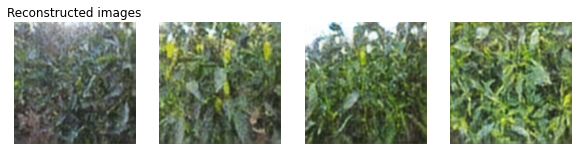


 EPOCH 262/300 	 train loss 0.01085 	 val loss 0.01059

 EPOCH 263/300 	 train loss 0.01083 	 val loss 0.01074

 EPOCH 264/300 	 train loss 0.01087 	 val loss 0.01068

 EPOCH 265/300 	 train loss 0.01088 	 val loss 0.01075

 EPOCH 266/300 	 train loss 0.01089 	 val loss 0.01056

 EPOCH 267/300 	 train loss 0.01091 	 val loss 0.01088

 EPOCH 268/300 	 train loss 0.01093 	 val loss 0.01084

 EPOCH 269/300 	 train loss 0.01143 	 val loss 0.02667

 EPOCH 270/300 	 train loss 0.01131 	 val loss 0.01667

 EPOCH 271/300 	 train loss 0.01113 	 val loss 0.01067

 EPOCH 272/300 	 train loss 0.01092 	 val loss 0.01044

 EPOCH 273/300 	 train loss 0.01084 	 val loss 0.0106

 EPOCH 274/300 	 train loss 0.01079 	 val loss 0.01037

 EPOCH 275/300 	 train loss 0.01077 	 val loss 0.01032

 EPOCH 276/300 	 train loss 0.01077 	 val loss 0.01035

 EPOCH 277/300 	 train loss 0.01075 	 val loss 0.01034

 EPOCH 278/300 	 train loss 0.01075 	 val loss 0.01044

 EPOCH 279/300 	 train loss 0.01076 	 val loss 0

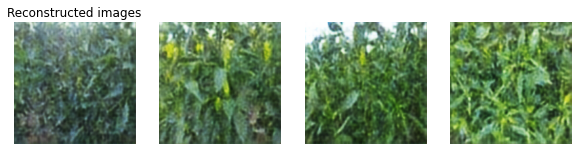


 EPOCH 282/300 	 train loss 0.01079 	 val loss 0.01032

 EPOCH 283/300 	 train loss 0.01082 	 val loss 0.01048

 EPOCH 284/300 	 train loss 0.01082 	 val loss 0.01046

 EPOCH 285/300 	 train loss 0.01088 	 val loss 0.01075

 EPOCH 286/300 	 train loss 0.01089 	 val loss 0.01058

 EPOCH 287/300 	 train loss 0.01092 	 val loss 0.01079

 EPOCH 288/300 	 train loss 0.01092 	 val loss 0.01062

 EPOCH 289/300 	 train loss 0.01089 	 val loss 0.01049

 EPOCH 290/300 	 train loss 0.01087 	 val loss 0.01064

 EPOCH 291/300 	 train loss 0.01093 	 val loss 0.0108

 EPOCH 292/300 	 train loss 0.01086 	 val loss 0.01055

 EPOCH 293/300 	 train loss 0.0108 	 val loss 0.0103

 EPOCH 294/300 	 train loss 0.01078 	 val loss 0.01026

 EPOCH 295/300 	 train loss 0.01079 	 val loss 0.0104

 EPOCH 296/300 	 train loss 0.0108 	 val loss 0.01028

 EPOCH 297/300 	 train loss 0.01079 	 val loss 0.0103

 EPOCH 298/300 	 train loss 0.01076 	 val loss 0.01035

 EPOCH 299/300 	 train loss 0.01075 	 val loss 0.0104

In [145]:
history_da = {"train_loss": [], "val_loss": []}
train_dataloader, val_dataloader = get_dataloaders(x, y)
image_batch = next(iter(val_dataloader))
plot_src_images(image_batch[0], NOISE_FACTOR)
for epoch in range(NUM_EPOCHS):
    ### Training
    train_loss = train_epoch_denoising(
        autoencoder=autoencoder,
        device=device,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        noise_factor=NOISE_FACTOR,
    )
    ### Validation
    val_loss = val_epoch_denoising(
        autoencoder=autoencoder,
        device=device,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
        noise_factor=NOISE_FACTOR,
    )
    #scheduler.step(val_loss.item())
    history_da["train_loss"].append(train_loss)
    history_da["val_loss"].append(val_loss)

    # Print Training and Validation losses
    print(
        f"\n EPOCH {epoch + 1}/{NUM_EPOCHS} \t train loss {round(train_loss.item(), 5)} \t val loss {round(val_loss.item(), 5)}"
    )
    # Plotting Reconstructed Images
    if (epoch % 20 == 0):
        plot_reconstructed_images(
            autoencoder, image_batch[0], noise_factor=NOISE_FACTOR
        )

## Possible Extensions
1. Change the Autoencoder architecture.
2. Use other dataset from the <a href="https://edenlibrary.ai">Eden platform</a>.
3. Change the noise factor.

## References
Alexandridis, T., Tamouridou, A.A., Pantazi, X., Lagopodi, A., Kashefi, J., Ovakoglou, G., Polychronos, V., & Moshou, D. (2017). Novelty Detection Classifiers in Weed Mapping: Silybum marianum Detection on UAV Multispectral Images. Sensors (Basel, Switzerland), 17.

Wen, C., Wu, D., Hu, H., & Pan, W. (2015). Pose estimation-dependent identification method for field moth images using deep learning architecture. Biosystems Engineering, 136, 117-128.

https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368

https://ai.plainenglish.io/denoising-autoencoder-in-pytorch-on-mnist-dataset-a76b8824e57e

https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/

https://github.com/python-engineer/pytorch-examples/blob/master/Autoencoder.ipynb

https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1